# PCA
선형대수 수업에서 배운거처럼 데이터의 특성의 수가 많을 경우 과대적합되기 쉽다는 문제가 있고 이를 방지하기 위해 필요한 특성만 뽑아(필요한 특성이라는 의미는 이따 씀) 특성의 수를 낮추는(차원 축소) 한 방법이다.

원래 데이터의 특성의 부분 공간(subspace)에 원래 데이터를 투영시킨다.(축소 평면에 수선의 발을 내린다)

## PCA 를 위한 데이터셋을 만든다.

In [2]:
import numpy as np
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

주성분을 찾는 과정은 데이터 - 평균을 한 다음 공분산 행렬을 찾아 고유치와 고유벡터를 구하는 것이다.
SVD로도 같은 과정을 수행할 수 있고 V가 주성분이다.

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## m -> d 차원으로 투영하기

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

위에서 사용한 방법은 PCA의 수학적 정의를 이용해 식을 적용한 것이고 사이킷런에서 PCA를 import하여 위 과정을 단순화 할 수 있다.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) #n_component를 2로 적용해 2차원으로 투영시킨다.
X2D = pca.fit_transform(X) 

In [13]:
X2D[:5] #투영된 2차원 데이터 다섯개를 뽑아오기

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [14]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

위 두 결과가 다른 이유는 그냥 축 방향이 뒤집혀서 그런거지 사실 같은 것이다.

### 재구성
일단 차원을 축소하면 축소하는 과정에서 데이터의 일부가 유실되므로 다시 원본 그대로 되돌리는 것은 불가능하다. 하지만 어느정도 되살리는 것은 가능하다. 아래 코드는 inver_transform을 사용하여 일부 데이터를 되살린 것과 원래 데이터의 오차를 확인하는 과정이다.

In [15]:
X3D_inv = pca.inverse_transform(X2D)

In [16]:
np.allclose(X3D_inv, X) #False가 나오는 이유는 바로 위에서 설명한대로 일부 데이터가 유실되었기 때문이다.

False

In [17]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1)) #재구성(복원) 오차를 확인

0.010170337792848549

### SVD 방식의 역변환

In [18]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 PCA클래스는 평균을 빼서 x_centered를 구했던 과정까지 알아서 거꾸로 돌려주기 때문에 그냥 수행하면 위에서 구한 역변환과 다른 결과가 나오지만 평균을 다시 빼주면 위에서 한 것과 같은 결과를 얻을 수 있다.

In [19]:
np.allclose(X3D_inv_using_svd, X3D_inv) #평균을 빼주지 않고 그냥 역변환 한 결과

False

In [20]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_) #역변환한 결과에서 평균을 빼준 결과

True

### 분산의 비율
차원 축소를 했을 때 분산이 어떻게 펼쳐지는지 알아야 잘 된건지 아닌지 얼만큼 차원을 더 추가해야되는지 알 수 있다.

In [21]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

첫번째 축에는 84% 두번째 축에는 14% 즉 두 축위에 98%가 넘는 데이터들이 올라가 있으므로 오차는 1%보다 좀 더 큰 수준이다.

In [22]:
1 - pca.explained_variance_ratio_.sum()


0.011195535570688975

## 적절한 차원 수 선택하기
위의 경우 2차원으로 축소했을 때 98.몇%라는 높은 결과를 얻었다(원본 데이터의 차원 수 자체가 낮아서 그렇겠지만) 그렇다면 엄청 큰 차원을 가진 데이터를 차원축소하려고 할 때 어느정도의 차원을 선택해야 손실을 최소화하면서 차원도 많이 줄일 수 있을까?(둘은 Trade-off관계이므로)

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [24]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

그냥 n_components를 내가 계속 조절해가며 원하는 분산이 나올 때 까지 시도할 수 있겠지만 반대로 분산을 얼마 이상이 될 때 까지 축을 알아서 선택하라고 지정해주는 방식이 존재한다.

In [25]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
d

154

154차원 정도로 축소해야 원하는 분산을 얻을 수 있다는 결과를 얻었다.

## 랜덤 PCA
svd_solver의 매개변수를 randomized로 지정하면 random PCA라 부르는 확률적 알고리즘을 사용해 처음 d개의 주성분에 대한 근삿값을 빠르게 찾는다. 복잡도가 SVD방식과 다르다. d가 n보다 많이 작을 경우 완전 SVD보다 훨씬 빠르다

In [27]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## 점진적 PCA
PCA구현의 문제점은 SVD알고리즘을 실행하기 위해선 전체 훈련 세트를 메모리에 올려야하는데 데이터셋이 크다면 불가능 할 것이다. 점진적 PCA(incremental PCA:IPCA)가 이를 보완하기 위해 개발되었다. 훈련 세트를 미니배치로 나눠서 IPCA알고리즘에 하나씩 주입한다. 이런 방식은 훈련세트가 클 때 뿐 아니라 온라인학습에도 사용할 수 있다.

In [28]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [34]:
X_reduced_inc_pca = X_reduced

In [35]:
np.allclose(pca.mean_, inc_pca.mean_)

True

## 커널 PCA
5장에서 다뤘던 커널트릭과 유사하게 차원축소를 할 때도 비선형 투형을 수행할 수 있다. 이를 커널PCA (kPCA)라고 하고 매니폴드에 가까운 데이터셋을 펼칠 때 유용하다. 아래 코드는 사이킷런의 KernelPCA를 사용해 RBF커널로 kPCA를 적용한 것이다.

In [38]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [39]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 커널 선택과 하이퍼파라미터 튜닝
kPCA는 비지도학습이므로 좋은 커널과 하이퍼파라미터를 선택하는 다른 방법이 없고 하나하나 넣어가며 결과를 보면서 선택해야한다. 다음 코드는 kPCA를 사용해 차원을 2차원으로 축소하고 로지스틱회귀를 적용하여 분류를 수행한다. 마지막으로 그리드서치를 사용해 가장 좋은 커널과 gamma 파라미터를 찾는 코드이다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

오류나는데 왜 나는지 모르겠다

## LLE (locally linear embedding)
또다른 비선형 차원축소 기술이다. 지금까지 다뤄왔던 방법과 달리 투영에 의존하지 않는다. 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어있는지 측정하고 국부적인 관계가 가장 잘 보존되는 훈련세트의 저차원 표현을 찾는다. 이 방법은 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동한다.

In [41]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

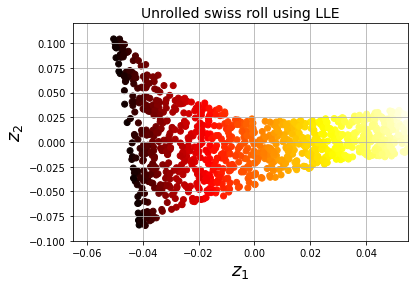

In [43]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)


plt.show()

왼쪽의 경우 좀 펼쳐져있고 오른쪽으로 갈수록 압축되어있긴 하지만 잘 모델링 된 것을 확인할 수 있다.